# Homework 3
- 姓名： 赵懿
- 学号： 21921266

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Sample from Normal Distribution
We need data! First, let's sample from **1** two variable normal distribution.

In [2]:
def sampleFrom2NormalPDF(_mean, _cov, size):
    return np.random.multivariate_normal(_mean, _cov, (size))

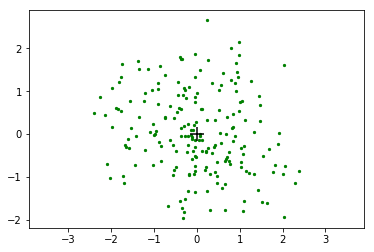

In [3]:
single_set = sampleFrom2NormalPDF(np.zeros(2), np.eye(2), 200)
# show
plt.axis('equal')
plt.scatter(single_set[:, 0], single_set[:, 1], s=5, c='g')
plt.scatter(0, 0, s=200, c='black', marker='+')
plt.show()

Not bad. Then sample from **3** two variable 2-d normal bistribution and use `probs` to control the probility that a point is smapled from each normal distribution.

In [4]:
def sampleFromMultiple2NormalPDF(num, _means, _covs, probs, size):
    latents = np.random.random(size)
    dataSet = []
    fakeLabels = []
    for i in range(num):
        latents-=probs[i]
        pointMask = latents<0
        dataSet.append(sampleFrom2NormalPDF(_means[i], _covs[i], np.sum(pointMask)))
        latents[pointMask] = np.inf
        fakeLabels += [i-1] * np.sum(pointMask)
    return np.vstack(dataSet), fakeLabels

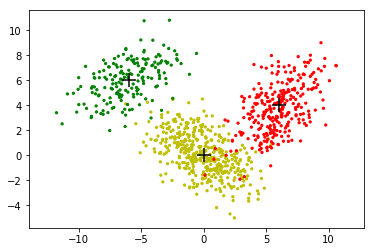

In [5]:
_means=np.array([[0,0],[6,4],[-6,6]])
_covs=np.array([[[5,-3],[0,2]],
                [[2,0],[3,5]],
                [[3,0],[4,3]]])
probs = [0.5, 0.3, 0.2]
mutiple_set, fakeLabels = sampleFromMultiple2NormalPDF(3, _means, _covs, probs, 900)
# show
palette = np.array(['r', 'g', 'y'])
plt.axis('equal')
plt.scatter(mutiple_set[:, 0], mutiple_set[:, 1], s=5, c=palette[fakeLabels])
plt.scatter(_means[:, 0], _means[:, 1], s=200, c='black', marker='+')
plt.show()

## Mean Shift
Next, let implement Mean Shift Cluter and use this algorithm estimate parameters $\theta$ of singe Gaussian Distribution and Gaussian Mixture Model respectively. Concretely, this task can be dividen into 2 steps:
- Step 1: Use **Mean Shift** algorithm compute all the cluster center and label for each point
- Step 2: Use **Maximum Likelihood Estimate** compute all the parameters for each 2-d Normal Distribution, inlcuding $\mu_i, \Sigma_i, \pi_i$. We directly use the result of MLE.
#### Mean Shift
First, let's implement Mean Shift algorithm. Generally, it consists of `shift` and `group` two processes.

In [6]:
def MeanShift(all_data, kernelBd, shift_thr, group_thr):
    shift_data = np.copy(all_data)
    numa = all_data.shape[0]
    unfix_idx = np.array(range(numa))
    # shift
    while True:
        iter_shift_data = shift_data[unfix_idx]
        numi = unfix_idx.shape[0]
        # compute distance, actuall distance square
        repeated_shift_data = np.repeat(iter_shift_data, numa, axis=0) # numi * numa
        tiled_all_data = np.tile(all_data, (numi, 1)) # numi * numa
        distances = np.sum((repeated_shift_data - tiled_all_data)**2, axis=1)

        # compute weight
        # just omit 1/(sqrt(2*pi)*kernelBd), after all we will do normoalize
        unnorm_weights = np.exp(-0.5*distances/(kernelBd**2))
        unnorm_weights = unnorm_weights.reshape((numi, numa))
        weight_sum = np.sum(unnorm_weights, axis=1)
        weights = (unnorm_weights.T / weight_sum).T # numi * numa

        # compute shifted data and shift_distance
        iter_shifted_data = weights@all_data # numi * 2
        shift_distance = np.linalg.norm(iter_shifted_data - iter_shift_data, axis=1)
        # update
        shift_data[unfix_idx] = iter_shifted_data

        # find unfix_idx
        unfix_mask = shift_distance > shift_thr
        if (unfix_mask == False).all():
            break
        unfix_idx = unfix_idx[unfix_mask]
    # group
    def createGroup(id, center):
        return {'id':id, 'center': center, 'size':1}
    
    group_id = 0
    groups = [createGroup(group_id, shift_data[0])]
    labels = [0]
    for sd in shift_data[1:]:
        found = False
        for group in groups:
            distance = np.sum((sd - group['center'])**2)
            if distance < group_thr:
                labels.append(group['id'])
                group['center'] = (group['center']*group['size'] + sd)/(group['size']+1)
                group['size'] += 1
                found = True
                break
        if found:
            continue
        group_id += 1
        groups.append(createGroup(group_id, sd))
        labels.append(group_id)
    
    return groups, np.array(labels)

#### Maximum Likelihood Estimate
Then let implement MLE and compute all the parameters.

In [7]:
def MLE4MeanShift(data, groups, label):
    n, _ = data.shape
    mus = []
    vas = []
    ws = []
    for group in groups:
        gdata = data[label == group['id']]
        mu = group['center']
        vas.append((gdata - mu).T@(gdata - mu) / group['size'])
        mus.append(mu)
        ws.append(group['size']/n)
    return np.array(mus), np.array(vas), np.array(ws)

#### Estimate
Now, with above 2 functions, we can cluster two datesets and estimate parameters for two model. First, let's try on single normal distribution.

In [8]:
def show_result(data, mus, vas, ws, label):
    # show
    print('clustering result:') 
    palette = np.array(['r', 'b', 'y', 'g', 'o'])# single I only set 5 color, so pray my alg won't cluster more than 5 center ^_^
    plt.axis('equal')
    plt.scatter(data[:, 0], data[:, 1], s=10, c=palette[label])
    plt.scatter(mus[:, 0], mus[:, 1], s=200, c='black', marker='+')
    plt.show()
    # print
    for i, (mu, va, w) in enumerate(zip(mus, vas, ws)):
        print('-------------Distribution {}------------'.format(i))
        print('mu:')
        print(mu)
        print('variance:')
        print(va)
        print('pi:')
        print(w)

clustering result:


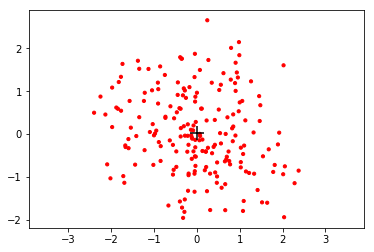

-------------Distribution 0------------
mu:
[-0.00351328  0.0312855 ]
variance:
[[ 1.04221636 -0.18054564]
 [-0.18054564  0.91458214]]
pi:
1.0


In [9]:
groups, label = MeanShift(single_set, 2, 0.001, 0.001)
mus, vas, ws = MLE4MeanShift(single_set, groups, label)
show_result(single_set, mus, vas, ws, label)

Then, use Mean Shift algorithm solve GMM problem.

clustering result:


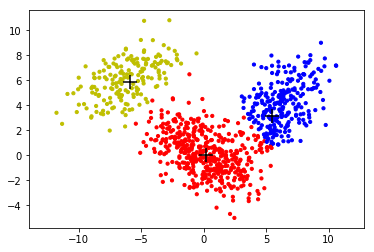

-------------Distribution 0------------
mu:
[0.2007365  0.02797225]
variance:
[[ 4.80983452 -1.40724581]
 [-1.40724581  2.84383449]]
pi:
0.5277777777777778
-------------Distribution 1------------
mu:
[5.45399098 3.11092014]
variance:
[[3.11355051 1.89195609]
 [1.89195609 4.15121819]]
pi:
0.2788888888888889
-------------Distribution 2------------
mu:
[-5.87751059  5.83547531]
variance:
[[4.43584702 1.78345617]
 [1.78345617 2.64480469]]
pi:
0.19333333333333333


In [10]:
groups, label = MeanShift(mutiple_set, 2, 0.001, 0.001)
mus, vas, ws = MLE4MeanShift(mutiple_set, groups, label)
show_result(mutiple_set, mus, vas, ws, label)

As we can see, clustering result and $\mu,\pi$ seem acceptable, however $\Sigma$ doesn't match the 'real' ones for GMM model.
## EM
We can also use **Expection Maximization** algorithm solve this GMM problem. E(Expection) step and M(Maximization) step comprise the main frame of EM algorithm. This time, I only use EM alg on the multiple normal distribution. 
> Note: When calling function `EM`, if you don't not provide the initial cluster centers alg will geneate a set of centers by sampling from m-d uniform. But it doesn't always work well, because sometimes some generate centers may be so far away from any 'real' center that, in clustering process, the center (moved center) can't get any point weights, which, in the end, causes a 'Singular Martix' fault in `multivariate_normal_pdf->np.linalg.inv()` function. If I were you, I will always provide cluster centers emplicitly.

In [11]:
def multivariate_normal_pdf(x, mu, va):
    _, d = x.shape
    va_inv = np.linalg.inv(va)
    exponential = -0.5*np.sum(np.multiply((x-mu)@va_inv, (x-mu)), axis=1)
    front = 1/(np.power(2*np.pi, d/2) * np.sqrt(np.linalg.det(va)))
    return front*np.exp(exponential)

def EM(data, cluster_num, iter_num, mus=None):
    # initialize
    n, m = data.shape
    if mus is None:
        _min = np.min(data, axis=0)
        _max = np.max(data, axis=0)
        mus = np.random.uniform(size=(cluster_num, m))*(_max - _min) + _min
    vas = np.array([np.eye(m) for i in range(cluster_num)])
    ws = np.ones(cluster_num) / cluster_num
    wsp = np.ones((n, cluster_num)) / cluster_num

    def E_step():
        nonlocal ws, wsp
        pdf = np.zeros((n, cluster_num))
        for i in range(cluster_num):
            pdf[:, i] = multivariate_normal_pdf(data, mus[i], vas[i])
        wsp = (pdf.T / np.sum(pdf, axis=1)).T
        ws = np.sum(wsp, axis=0) / np.sum(wsp)
    
    def M_step():
        nonlocal mus, vas
        for i in range(cluster_num):
            mus[i] = np.average(data, axis=0, weights=wsp[:, i])
            vas[i] = ((data-mus[i]).T*wsp[:, i])@(data-mus[i])/n
    
    for _ in range(iter_num):
        E_step()
        M_step()
    
    label = np.argmax(wsp, axis=1)
    return mus, vas, ws, label

Let's see what will happen if we let computer randomly select initial cluster centers. You may see a 'bad' cluster result and sometimes you may even **receive a fault** like 'Singular Matrix' or 'Weight sum is zeros' becasue program is trying to compute the inverse matrix of a singluar $\Sigma$. But if you are luck, you can also get a pretty good result, who knows.

clustering result:


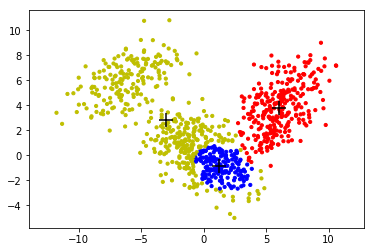

-------------Distribution 0------------
mu:
[6.05099898 3.75080958]
variance:
[[0.85393784 0.50817217]
 [0.50817217 1.22789344]]
pi:
0.3158769832794408
-------------Distribution 1------------
mu:
[ 1.21531443 -0.88267133]
variance:
[[ 0.25096835 -0.05285109]
 [-0.05285109  0.14493509]]
pi:
0.19551634913087576
-------------Distribution 2------------
mu:
[-3.02099002  2.83186948]
variance:
[[ 5.09548491 -3.25181863]
 [-3.25181863  4.80029705]]
pi:
0.4886066675896836


In [14]:
mus, vas, ws, label=EM(mutiple_set, 3, 5)
show_result(mutiple_set, mus, vas, ws, label)

But if you give program a set of 'not so bad' cluster centers, I believe you can get a 'not so bad' response:

clustering result:


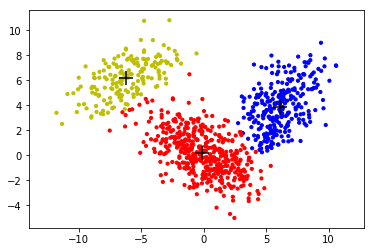

-------------Distribution 0------------
mu:
[-0.12807417  0.1639622 ]
variance:
[[ 2.42810773 -1.03291625]
 [-1.03291625  1.58040668]]
pi:
0.5128751552184339
-------------Distribution 1------------
mu:
[6.14714387 3.87821567]
variance:
[[0.77204042 0.41399201]
 [0.41399201 1.08710602]]
pi:
0.3040826374578501
-------------Distribution 2------------
mu:
[-6.17695995  6.18708589]
variance:
[[0.83109148 0.35867653]
 [0.35867653 0.4260317 ]]
pi:
0.18304220732371604


In [13]:
initial_centers = np.array([[1., -1.],[5.,5.],[-5.,7.]])
mus, vas, ws, label=EM(mutiple_set, 3, 5, initial_centers)
show_result(mutiple_set, mus, vas, ws, label)

Same as Mean Shift, clustering result and $\mu,\pi$ seem acceptable, variance $\Sigma$ looks even wrose than Mean Shift. So I prefer Mean Shift algorithm, because when clustering, campared with EM, it:
- Does not require data to follow Gaussian distribution, it even does not assume the variance of the distribution of each attribute (variable) is spherical
- Does not need human select the number and vaule of cluster center